In [2]:
import pandas as pd

df = pd.read_csv('preprocessed_processed_image.csv')
df

,선종,상태,state,vessel_type,nation_type
0,낚시어선,조업,0,8,1
1,범장망,조업,0,3,0
2,낚시어선,표류,2,8,1
3,등광조망,이동,1,2,0
4,등광조망,표류,2,2,0
...,...,...,...,...,...
1576,안강망,조업,0,4,1
1577,연승,표류,2,5,1
1578,등광조망,조업,0,2,0
1579,등광조망,조업,0,2,0


In [25]:
import os
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical


# 이미지 디렉토리 경로
image_dir = 'imgdata'  # 경로 수정 필요

# 이미지 읽기 및 전처리
images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.png')):  # 여러 확장자를 처리
        img_path = os.path.join(image_dir, filename)
        try:
            image = Image.open(img_path).convert('RGB').resize((256, 256))  # 이미지 크기 조정 및 RGB 변환
            # 대비 증가
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(2.0)
            
            image_array = img_to_array(image) / 255.0  # 정규화
            images.append(image_array)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

# 이미지 데이터를 NumPy 배열로 변환
images = np.array(images)

train_data = images
train_data
target = df['vessel_type']
target = to_categorical(target, num_classes=10)
target

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [3]:
# !pip install imbalanced-learn

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def ResNet50(input_shape=(256, 256, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNetV2 backbone
    backbone = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')(inputs)
    
    # Add custom head for classification
    x = layers.GlobalAveragePooling2D()(backbone)
    x = layers.Dense(128, activation='softmax')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ResNet50')
    return model

model = ResNet50()
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 23,798,154 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
# 300 -> 100 -> 100 -> 50 학습 횟수 반복 순서
history = model.fit(train_data, target, epochs=550, verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8845 - loss: 0.3699
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8862 - loss: 0.3642
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8810 - loss: 0.3635
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8887 - loss: 0.3398
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8802 - loss: 0.3635
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8794 - loss: 0.3938
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8803 - loss: 0.3821
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8602 - loss: 0.4225
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8471 - loss: 0.4588
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7911 - loss: 0.7735
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7655 - loss: 0.8309
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy:

In [42]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

test_image_dir = '테스트셋'  # 이미지 폴더 경로

# 이미지 읽기 및 전처리
test_images = []  # 리스트로 선언

# 파일 목록을 가져오고 숫자 순서대로 정렬
file_list = sorted(os.listdir(test_image_dir), key=lambda x: int(os.path.splitext(x)[0]))

for filename in file_list:
    if filename.lower().endswith(('.jpg', '.png')):  # 확장자를 소문자로 변환 후 비교
        img_path = os.path.join(test_image_dir, filename)
        try:
            image = Image.open(img_path).convert('RGB').resize((256, 256))  # 이미지 크기 조정 및 RGB 변환
            # 대비 증가
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(2.0)
            image_array = img_to_array(image) / 255.0  # 이미지를 배열로 변환하고 정규화
            test_images.append(image_array)  # 리스트에 이미지 추가
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

# 이미지 데이터를 NumPy 배열로 변환
test_images = np.array(test_images)  # 리스트를 한 번에 NumPy 배열로 변환

test_data = test_images
print(test_data)


[[[[1.         1.         1.        ]
   [0.45882353 0.41960785 0.3882353 ]
   [0.21568628 0.1764706  0.1764706 ]
   ...
   [0.21568628 0.2        0.21568628]
   [0.21568628 0.2        0.22352941]
   [0.22352941 0.20784314 0.23921569]]

  [[1.         1.         1.        ]
   [0.11372549 0.09019608 0.06666667]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[1.         1.         1.        ]
   [0.14509805 0.12156863 0.08235294]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[1.         1.         1.        ]
   [0.11372549 0.11372549 0.09019608]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[1.         1.         1.        ]
   [0.1

In [53]:
import numpy as np

# 예측 값 숫자를 대응하는 문자열로 매핑
class_mapping = {
    0: "타망",
    1: "유망",
    2: "등광조망",
    3: "범장망",
    4: "안강망",
    5: "연승",
    6: "통발",
    7: "저인망",
    8: "낚시어선",
    9: "채낚기"
}

# 예측 진행
predictions = model.predict(test_data)
class_predictions = np.argmax(predictions, axis=1)

# 파일명과 예측된 결과를 저장할 리스트 생성
file_names = []
prediction_labels = []

# 파일명과 예측된 결과를 리스트에 추가
for filename, prediction in zip(file_list, class_predictions):
    prediction_label = class_mapping[prediction]  # 숫자를 글자로 변환
    print(f"File: {filename}, Prediction: {prediction_label}")
    file_names.append(filename)
    prediction_labels.append(prediction_label)

import pandas as pd

# DataFrame 생성
result = pd.DataFrame({'파일명': file_names, '선종': prediction_labels})

# 결과 확인
result
# CSV 파일로 저장
result.to_csv('vessel_type_result.csv', index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
File: 1.jpg, Prediction: 범장망
File: 2.jpg, Prediction: 등광조망
File: 3.jpg, Prediction: 등광조망
File: 4.jpg, Prediction: 채낚기
File: 5.jpg, Prediction: 타망
File: 6.jpg, Prediction: 등광조망
File: 7.jpg, Prediction: 등광조망
File: 8.jpg, Prediction: 범장망
File: 9.jpg, Prediction: 범장망
File: 10.jpg, Prediction: 범장망
File: 11.jpg, Prediction: 유망
File: 12.jpg, Prediction: 낚시어선
File: 13.jpg, Prediction: 범장망
File: 14.jpg, Prediction: 범장망
File: 15.jpg, Prediction: 낚시어선
File: 16.jpg, Prediction: 낚시어선
File: 17.jpg, Prediction: 타망
File: 18.jpg, Prediction: 통발
File: 19.jpg, Prediction: 등광조망
File: 20.jpg, Prediction: 범장망
File: 21.jpg, Prediction: 저인망
File: 22.jpg, Prediction: 낚시어선
File: 23.jpg, Prediction: 유망
File: 24.jpg, Prediction: 타망
File: 25.jpg, Prediction: 낚시어선
File: 26.jpg, Prediction: 안강망
File: 27.jpg, Prediction: 타망
File: 28.jpg, Prediction: 타망
File: 29.jpg, Prediction: 타망
File: 30.jpg, Prediction: 낚시어선
File: 31.jpg, Prediction: 타망
File: 32.jpg, Prediction: 등광조망
File: 33.

In [ ]:
import pandas as pd
result = pd.DataFrame({})

In [44]:
# 모델 HDF5 형식으로 저장
model.save('resnet50_model.h5')

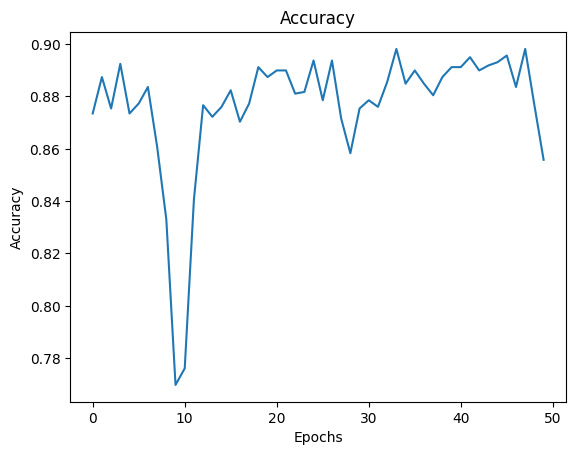

In [47]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.show()

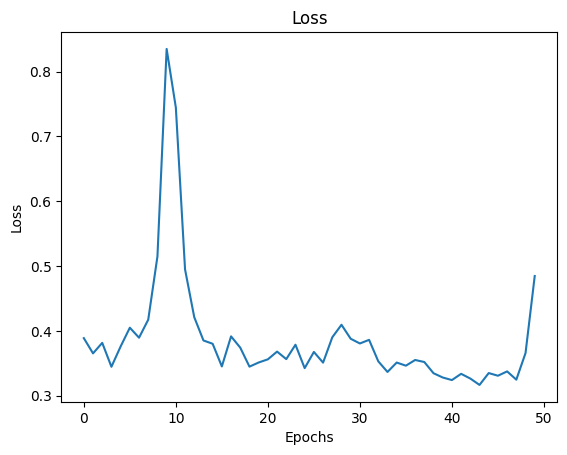

In [48]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.show()